# Deteksi Outlier dengan K-Nearest Neighbors (KNN) dalam Data Understanding

## Mengapa KNN Bisa Digunakan untuk Deteksi Outlier?

KNN merupakan algoritma berbasis jarak yang memanfaatkan hubungan antar data dalam ruang berdimensi. Dalam deteksi outlier, konsep utama yang digunakan adalah kedekatan antar data dan kepadatannya.

Bayangkan dataset sebagai sekumpulan titik di peta:
- Titik yang berada jauh dari kelompok lain dapat dianggap sebagai outlier.
- Titik yang memiliki sedikit tetangga di sekitarnya juga bisa dicurigai sebagai outlier.

Dengan kata lain, jika suatu data memiliki tetangga yang jauh atau sangat sedikit, maka kemungkinan besar data tersebut adalah outlier.

## Langkah-Langkah Deteksi Outlier dengan KNN

a. Menghitung Jarak Antar Titik

- Kita bisa menggunakan metrik jarak seperti Euclidean Distance atau Manhattan Distance untuk melihat kedekatan antar titik.
- Jika titik tertentu memiliki jarak yang jauh dibandingkan dengan data lainnya, maka ia berpotensi menjadi outlier.

b. Menentukan K (Jumlah Tetangga Terdekat)

- Kecilkan K, dan kita akan lebih sensitif terhadap noise (kesalahan kecil bisa dianggap outlier).
- Besarkan K, dan model akan lebih toleran terhadap outlier tapi bisa kehilangan sensitivitasnya.

c. Menilai Kejanggalan Data (Outlier Score)

Beberapa cara untuk menilai apakah suatu titik adalah outlier:
- Average Distance to K Nearest Neighbors
→ Mengukur jarak rata-rata suatu titik ke tetangga terdekatnya. Jika terlalu besar, titik tersebut dicurigai sebagai outlier.
- Local Outlier Factor (LOF)
→ Membandingkan kepadatan suatu titik dengan kepadatan tetangganya. Jika titik memiliki kepadatan rendah, maka lebih mungkin menjadi outlier.
- K-Distance Neighborhood
→ Menentukan jumlah tetangga dalam radius tertentu. Jika jumlahnya terlalu sedikit, kemungkinan besar itu adalah outlier

## Kesimpulan
KNN bukan hanya digunakan untuk klasifikasi atau regresi, tetapi juga alat yang sangat kuat dalam memahami struktur data, terutama dalam mendeteksi anomali atau outlier. Dengan memahami distribusi jarak antar titik, kita dapat menyingkirkan data yang mencurigakan dan memastikan analisis lebih akurat.

In [23]:
%pip install pymysql
%pip install psycopg2

Kode di atas berfungsi untuk menginstal dua pustaka Python, yaitu "pymysql" dan "psycopg2", yang digunakan sebagai konektor ke database. "pymysql" memungkinkan Python berkomunikasi dengan **MySQL atau MariaDB** menggunakan protokol MySQL, sedangkan "psycopg2" digunakan untuk menghubungkan Python dengan **PostgreSQL**, menyediakan antarmuka yang optimal untuk menjalankan query SQL serta berinteraksi dengan database tersebut.

Kedua perintah ini menggunakan **magic command** (%pip), yang biasanya digunakan dalam **Jupyter Notebook** untuk memastikan instalasi pustaka dilakukan dalam lingkungan (kernel) yang sedang aktif, sehingga dapat langsung digunakan dalam sesi notebook yang berjalan.

 id           class  petal_length  petal_width  sepal_length  sepal_width  knn_distance  outlier_knn
  1     Iris-setosa          14.0          2.0          51.0         35.0     11.269871         True
  2     Iris-setosa          14.0          2.0          40.9         30.0     11.269871         True
  3     Iris-setosa          13.0          2.0          47.0         32.0      6.496922        False
  4     Iris-setosa          15.0          2.0          46.0         31.0      6.480741        False
  5     Iris-setosa          14.0          2.0          50.0         36.0     10.900000         True
  6     Iris-setosa           1.7          0.4          54.0         39.0     17.534252         True
  7     Iris-setosa           1.4          0.3           4.6          3.4      0.316228        False
  8     Iris-setosa           1.5          0.2           5.0          3.4      0.223607        False
  9     Iris-setosa           1.4          0.2           4.4          2.9      0.360555    

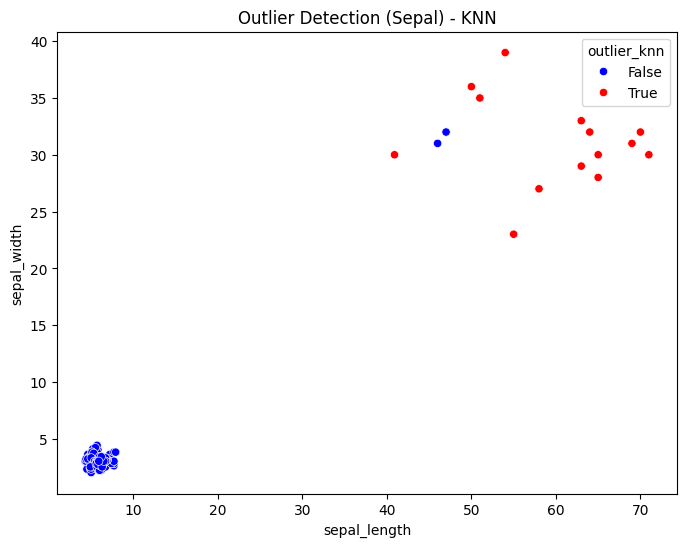

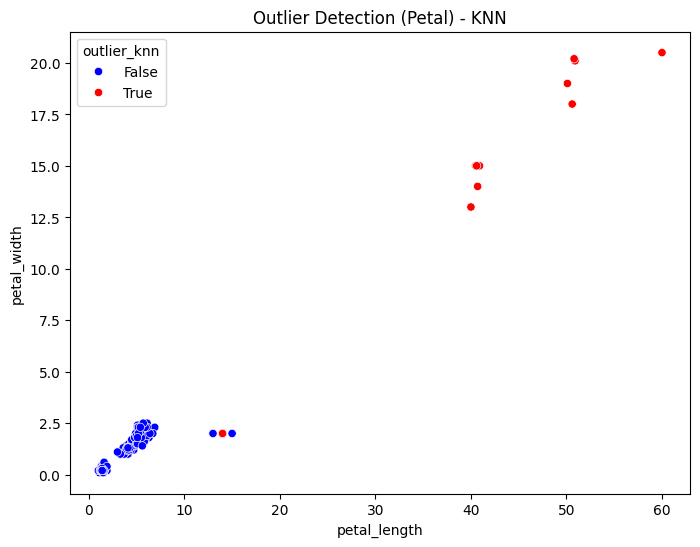

In [24]:
import psycopg2
import pymysql
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

def get_pg_data():
    conn = psycopg2.connect(
        host="pg-382999bb-posgresqlpendataa.g.aivencloud.com",
        user="avnadmin",
        password="AVNS_AwzON_kzF3kYXNu_CrZ",
        database="defaultdb",
        port=11188
    )
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM nabila.postgres;")
    data = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]
    cursor.close()
    conn.close()
    return pd.DataFrame(data, columns=columns)

def get_mysql_data():
    conn = pymysql.connect(
        host="mysql-9b686fb-pendataa.g.aivencloud.com",
        user="avnadmin",
        password="AVNS_ZuFdVS1OQkmHx4P1Wtp",
        database="defaultdb",
        port=22825
    )
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM irismysql")
    data = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]
    cursor.close()
    conn.close()
    return pd.DataFrame(data, columns=columns)

# Ambil data dari kedua database
df_postgresql = get_pg_data()
df_mysql = get_mysql_data()

# Gabungkan berdasarkan kolom 'id'
df_merged = pd.merge(df_mysql, df_postgresql, on=["id", "class"], how="inner")

# Ambil data fitur numerik
feature_columns = ["petal_length", "petal_width", "sepal_length", "sepal_width"]
data_values = df_merged[feature_columns].values

# KNN Outlier Detection
def knn_outlier_detection(data, k=5):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(data)
    distances, _ = neigh.kneighbors(data)
    avg_distances = distances[:, -1]  # Ambil jarak k-terjauh sebagai skor
    return avg_distances

# Hitung K-NN distance
df_merged["knn_distance"] = knn_outlier_detection(data_values, k=5)

# Tentukan threshold sebagai nilai rata-rata + 2 standar deviasi
threshold = df_merged["knn_distance"].mean() + 2 * df_merged["knn_distance"].std()
df_merged["outlier_knn"] = df_merged["knn_distance"] > threshold

# Cetak hasil
df_result = df_merged[["id", "class", "petal_length", "petal_width", "sepal_length", "sepal_width", "knn_distance", "outlier_knn"]]
print(df_result.to_string(index=False))
num_outliers = df_merged["outlier_knn"].sum()
print(f"\nJumlah outlier: {num_outliers}")

# Cetak data outlier
outliers = df_merged[df_merged["outlier_knn"]]
print("\nData Outlier:")
print(outliers.to_string(index=False))

# Visualisasi outlier berdasarkan K-NN
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_merged["sepal_length"], y=df_merged["sepal_width"],
    hue=df_merged["outlier_knn"], palette={False: "blue", True: "red"}
)
plt.title("Outlier Detection (Sepal) - KNN")
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_merged["petal_length"], y=df_merged["petal_width"],
    hue=df_merged["outlier_knn"], palette={False: "blue", True: "red"}
)
plt.title("Outlier Detection (Petal) - KNN")
plt.show()

Kode diatas ini bertujuan untuk mendeteksi outlier menggunakan metode K-Nearest Neighbors (KNN) pada data yang diambil dari dua database berbeda, yaitu PostgreSQL dan MySQL. Prosesnya dimulai dengan mengambil data dari kedua database, lalu menggabungkannya berdasarkan kolom 'id' dan 'class'. Setelah data terintegrasi, kode ini mengekstrak fitur numerik yang relevan, seperti panjang dan lebar sepal serta petal, yang kemudian digunakan untuk analisis lebih lanjut

**Metode KNN** dalam deteksi outlier bekerja dengan mengukur kedekatan antara satu titik data dengan titik-titik lain dalam ruang fitur. Fungsi (knn_outlier_detection) yang digunakan dalam kode ini menerapkan algoritma KNN untuk menentukan jarak antara setiap titik data dengan lima tetangga terdekat (k = 5). Dari lima tetangga tersebut, jarak terjauh digunakan sebagai skor jarak untuk setiap titik. Semakin besar nilai skor ini, semakin besar kemungkinan data tersebut merupakan outlier.

Agar bisa menentukan apakah suatu titik adalah outlier atau bukan, kode ini menetapkan ambang batas (threshold) berdasarkan rata-rata skor jarak ditambah dua kali standar deviasi. Jika skor jarak suatu titik melebihi threshold tersebut, maka titik tersebut diklasifikasikan sebagai outlier.

Hasil deteksi ini ditambahkan dalam kolom baru yang menunjukkan status outlier (True/False) untuk setiap data. Selain itu, kode ini juga menampilkan hasil deteksi dalam bentuk scatter plot, di mana data outlier ditandai dengan warna merah, sementara data lainnya ditampilkan dalam warna biru. Sebagai tambahan, kode ini juga mencetak jumlah outlier yang ditemukan serta menampilkan detail titik-titik yang teridentifikasi sebagai outlier

## Memisahkan outlier dari data

In [25]:
import psycopg2
import pymysql
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split , KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, Normalizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.inspection import DecisionBoundaryDisplay

def get_pg_data():
    conn = psycopg2.connect(
        host="pg-382999bb-posgresqlpendataa.g.aivencloud.com",
        user="avnadmin",
        password="AVNS_AwzON_kzF3kYXNu_CrZ",
        database="defaultdb",
        port=11188
    )
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM nabila.postgres;")
    data = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]
    cursor.close()
    conn.close()
    return pd.DataFrame(data, columns=columns)

def get_mysql_data():
    conn = pymysql.connect(
        host="mysql-144b909e-mysqlll.g.aivencloud.com",
        user="avnadmin",
        password="AVNS_UkzghDQ6mbisK-glP-x",
        database="iris",
        port=17474
    )
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM irismysql")
    data = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]
    cursor.close()
    conn.close()
    return pd.DataFrame(data, columns=columns)

# Ambil data dari kedua database
df_postgresql = get_pg_data()
df_mysql = get_mysql_data()

# Gabungkan berdasarkan kolom 'id' dan 'class'
df_merge = pd.merge(df_mysql, df_postgresql, on=["id", "class"], how="inner")

# Ambil data fitur numerik tanpa kolom 'class'
feature_columns = ["petal_length", "petal_width", "sepal_length", "sepal_width"]
data_values = df_merge[feature_columns].values

# Inisialisasi model LOF
clf = LocalOutlierFactor(n_neighbors=90)
label = clf.fit_predict(data_values)

# Tambahkan hasil label ke dataframe
df_merge["outlier_label"] = label

# Cetak hasil dengan ID dan class
print(df_merge.to_string(index=False))

num_outliers = (label == -1).sum()
print(f"\nJumlah outlier: {num_outliers}")
df_filtered = df_merge[label == 1].drop(columns=["outlier_label"], errors='ignore')
outliers = df_merge[label == -1].drop(columns=["outlier_label"], errors='ignore')
print("\nData Outlier:")
print(outliers.to_string(index=False))
print("\nJumlah data setelah dihapus : ",len(df_filtered))
print("\nData tidak outlier :")
print(df_filtered.to_string(index=False))

 id           class  petal_length  petal_width  sepal_length  sepal_width  outlier_label
  1     Iris-setosa           1.4          0.2          51.0         35.0             -1
  2     Iris-setosa          14.0          2.0          40.9         30.0             -1
  3     Iris-setosa           1.3          0.2          47.0         32.0             -1
  4     Iris-setosa           1.5          0.2          46.0         31.0             -1
  5     Iris-setosa           1.4          0.2          50.0         36.0             -1
  6     Iris-setosa           1.7          0.4          54.0         39.0             -1
  7     Iris-setosa           1.4          0.3           4.6          3.4              1
  8     Iris-setosa           1.5          0.2           5.0          3.4              1
  9     Iris-setosa           1.4          0.2           4.4          2.9              1
 10     Iris-setosa           1.5          0.1           4.9          3.1              1
 11     Iris-setosa  

Kode diatas ini berfungsi untuk mengidentifikasi serta memisahkan data outlier dari dataset yang diperoleh dari dua sumber basis data yang berbeda, yakni PostgreSQL dan MySQL. Langkah pertama yang dilakukan adalah membangun koneksi ke masing-masing basis data menggunakan pustaka psycopg2 untuk PostgreSQL dan pymysql untuk MySQL. Setelah koneksi berhasil, kode mengeksekusi query untuk mengambil seluruh data dari tabel iris_postgresql dan irismysql. Data yang diperoleh kemudian dikonversi menjadi bentuk DataFrame menggunakan pustaka pandas.

Kedua dataset yang berasal dari PostgreSQL dan MySQL kemudian digabungkan dengan metode inner join berdasarkan kolom id dan class. Dengan metode ini, hanya data yang terdapat di kedua tabel yang akan tetap dipertahankan dalam dataset akhir. Selanjutnya, hanya kolom yang berisi nilai numerik yang digunakan untuk proses deteksi outlier, yaitu petal_length, petal_width, sepal_length, dan sepal_width.

Untuk mengidentifikasi outlier, digunakan metode Local Outlier Factor (LOF) dari pustaka scikit-learn. Model ini diterapkan dengan parameter n_neighbors=90, yang berarti setiap data dibandingkan dengan 90 tetangga terdekatnya untuk menentukan apakah termasuk dalam kategori outlier atau bukan. Model LOF memberikan label 1 untuk data yang dianggap normal, sementara data yang terdeteksi sebagai outlier akan diberi label -1.

Setelah model dijalankan, label hasil deteksi disimpan dalam kolom baru bernama outlier_label di dalam DataFrame. Dari hasil yang diperoleh, jumlah total data yang dikategorikan sebagai outlier dihitung berdasarkan banyaknya nilai -1 dalam kolom tersebut. Dataset kemudian dipisahkan menjadi dua bagian, yaitu df_filtered yang berisi data normal (label 1) dan outliers yang berisi data yang dianggap sebagai outlier (label -1).

Sebagai langkah akhir, program mencetak hasil deteksi outlier, termasuk jumlah total data yang dikategorikan sebagai outlier, daftar data yang termasuk dalam kategori tersebut, serta data yang tersisa setelah pembersihan. Dengan metode ini, outlier dalam dataset dapat diidentifikasi dan dihilangkan sebelum digunakan untuk analisis lebih lanjut, sehingga kualitas data yang digunakan dalam pemodelan pembelajaran mesin menjadi lebih baik dan minim bias.

## Menghitung Akurasi dari data

In [26]:
X = df_merged[feature_columns]
y = df_merged["class"]

# Encode label kelas ke numerik
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Menerapkan LOF untuk deteksi outlier
lof = LocalOutlierFactor(n_neighbors=90, contamination=0.1)
outlier_labels = lof.fit_predict(X)
df_merged["outlier"] = outlier_labels

# Pisahkan data dengan outlier dan tanpa outlier
df_cleaned = df_merged[df_merged["outlier"] == 1].drop(columns=["outlier"])

# Membagi data menjadi training (80%) dan testing (20%)
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(
    df_cleaned[feature_columns],
    label_encoder.transform(df_cleaned["class"]),
    test_size=0.2,
    random_state=42
)

# Pipeline dengan StandardScaler dan KNN
knn_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=11))
])

# Latih model pada data dengan outlier
knn_pipeline.fit(X_train_all, y_train_all)
y_pred_all = knn_pipeline.predict(X_test_all)
accuracy_all = accuracy_score(y_test_all, y_pred_all)
print("Akurasi dengan outlier:", accuracy_all)
print(classification_report(y_test_all, y_pred_all, target_names=label_encoder.classes_))

# Latih model pada data tanpa outlier
knn_pipeline.fit(X_train_clean, y_train_clean)
y_pred_clean = knn_pipeline.predict(X_test_clean)
accuracy_clean = accuracy_score(y_test_clean, y_pred_clean)
print("Akurasi tanpa outlier:", accuracy_clean)
print(classification_report(y_test_clean, y_pred_clean, target_names=label_encoder.classes_))

Akurasi dengan outlier: 0.9666666666666667
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.90      1.00      0.95         9
 Iris-virginica       1.00      0.91      0.95        11

       accuracy                           0.97        30
      macro avg       0.97      0.97      0.97        30
   weighted avg       0.97      0.97      0.97        30

Akurasi tanpa outlier: 0.9259259259259259
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        12
Iris-versicolor       0.86      0.86      0.86         7
 Iris-virginica       0.88      0.88      0.88         8

       accuracy                           0.93        27
      macro avg       0.91      0.91      0.91        27
   weighted avg       0.93      0.93      0.93        27



Kode diatas ini dirancang untuk menganalisis perbedaan akurasi dan hasil klasifikasi model K-Nearest Neighbors (KNN) pada dataset yang mengandung outlier dan yang telah dibersihkan dari outlier. Langkah awal yang dilakukan adalah memilih fitur numerik dari DataFrame gabungan yang akan digunakan dalam pemodelan. Selain itu, label kelas dikonversi menjadi bentuk numerik menggunakan LabelEncoder agar bisa diproses oleh model pembelajaran mesin.

Metode Local Outlier Factor (LOF) digunakan kembali untuk mendeteksi outlier dengan parameter n_neighbors=90 dan contamination=0.1, yang berarti sekitar 10% data akan diklasifikasikan sebagai outlier. Setelah proses ini selesai, hasil deteksi outlier ditambahkan ke dalam DataFrame, sehingga dataset terbagi menjadi dua kelompok: satu yang masih mengandung outlier dan satu lagi yang telah dibersihkan dari outlier.

Selanjutnya, kedua dataset tersebut dibagi menjadi dua subset, yaitu data latih (training set) sebanyak 80% dan data uji (testing set) sebanyak 20%, menggunakan fungsi train_test_split. Dengan demikian, terdapat dua set pelatihan dan pengujian—satu dari dataset yang masih mengandung outlier dan satu lagi dari dataset yang sudah dibersihkan.

Model KNN diterapkan dengan jumlah tetangga 11, menggunakan Pipeline agar data dapat diproses secara lebih terstruktur. Sebelum model dilatih, data terlebih dahulu distandarkan menggunakan StandardScaler untuk memastikan setiap fitur memiliki skala yang seragam. Model pertama dilatih menggunakan dataset yang masih mengandung outlier, lalu hasil prediksi dari data uji dibandingkan dengan label aslinya. Akurasi dihitung, dan laporan klasifikasi (classification report) ditampilkan untuk melihat metrik evaluasi seperti precision, recall, dan F1-score untuk setiap kelas.

Proses yang sama dilakukan pada dataset yang telah dibersihkan dari outlier. Pada akhirnya, kode ini menghasilkan dua nilai akurasi: satu untuk model yang dilatih dengan data yang mengandung outlier dan satu lagi untuk model yang telah melalui proses pembersihan outlier. Selain itu, laporan klasifikasi disediakan untuk membantu menilai sejauh mana keberadaan outlier memengaruhi kinerja model.

Secara teori, model yang dilatih menggunakan data yang telah dibersihkan dari outlier seharusnya memiliki akurasi lebih tinggi, karena outlier dapat menyebabkan gangguan dalam perhitungan jarak pada algoritma KNN. Dengan membandingkan hasil kedua model ini, pengguna dapat memahami pengaruh keberadaan outlier terhadap performa klasifikasi serta menilai apakah proses pembersihan outlier berkontribusi pada peningkatan akurasi model.

## Visualisasi data

Akurasi: 0.9259259259259259
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        11
Iris-versicolor       1.00      0.75      0.86         8
 Iris-virginica       0.80      1.00      0.89         8

       accuracy                           0.93        27
      macro avg       0.93      0.92      0.92        27
   weighted avg       0.94      0.93      0.92        27



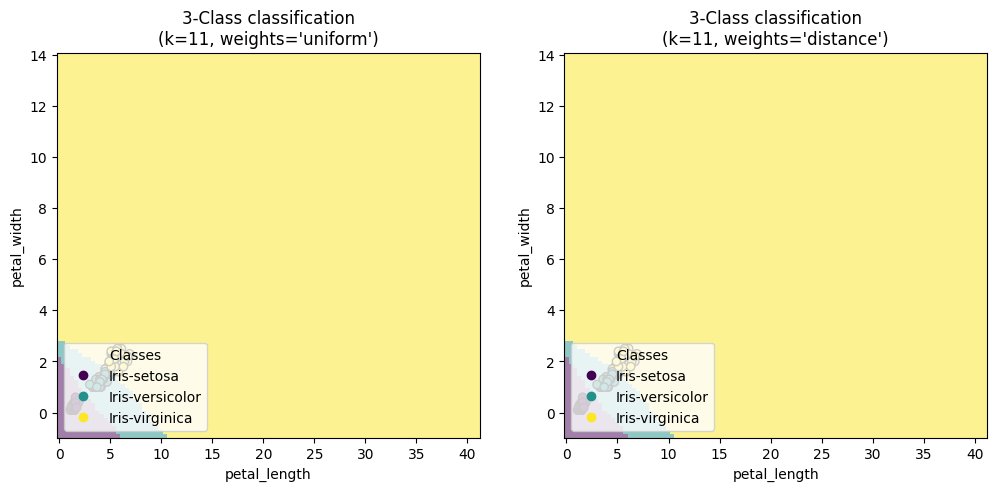

In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.inspection import DecisionBoundaryDisplay

# Ambil dua fitur utama untuk visualisasi decision boundary
feature_columns = ["petal_length", "petal_width"]
X = df_cleaned[feature_columns]
y = df_cleaned["class"]

# Encode label kelas ke numerik
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Ubah nama kelas jadi angka

# Membagi data menjadi training (80%) dan testing (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

# Pipeline dengan KNN dan StandardScaler
clf = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=11))
])

# Pelatihan model KNN
clf.fit(X_train, y_train)

# Evaluasi model
y_pred = clf.predict(X_test)
print(f"Akurasi: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Visualisasi Decision Boundary
_, axs = plt.subplots(ncols=2, figsize=(12, 5))

for ax, weights in zip(axs, ("uniform", "distance")):
    clf.set_params(knn__weights=weights).fit(X_train, y_train)
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X_test,
        response_method="predict",
        plot_method="pcolormesh",
        xlabel=feature_columns[0],
        ylabel=feature_columns[1],
        shading="auto",
        alpha=0.5,
        ax=ax,
    )
    scatter = disp.ax_.scatter(
        X_train.iloc[:, 0], X_train.iloc[:, 1],
        c=y_train, edgecolors="k", cmap="viridis"
    )
    disp.ax_.legend(
        scatter.legend_elements()[0],
        label_encoder.classes_,
        loc="lower left",
        title="Classes",
    )
    _ = disp.ax_.set_title(
        f"3-Class classification\n(k={clf[-1].n_neighbors}, weights={weights!r})"
    )

plt.show()

Akurasi: 0.7407407407407407
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        11
Iris-versicolor       0.57      0.50      0.53         8
 Iris-virginica       0.56      0.62      0.59         8

       accuracy                           0.74        27
      macro avg       0.71      0.71      0.71        27
   weighted avg       0.74      0.74      0.74        27



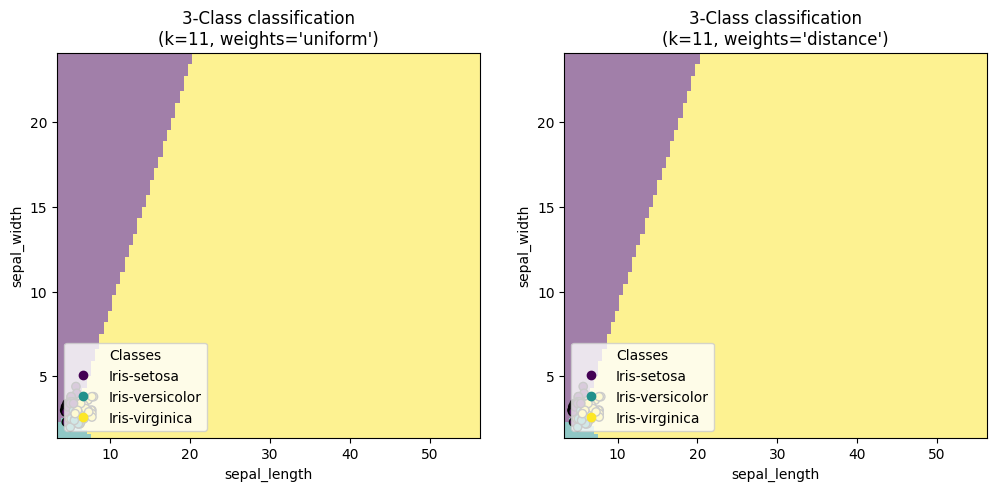

In [28]:
import psycopg2
import pymysql
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.inspection import DecisionBoundaryDisplay


# Ambil dua fitur utama untuk visualisasi decision boundary
feature_columns = ["sepal_length", "sepal_width"]
X = df_merged[feature_columns]
y = df_merged["class"]

# Encode label kelas ke numerik
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Mengubah nama kelas menjadi angka

# Menerapkan LOF untuk deteksi outlier
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
outlier_labels = lof.fit_predict(X)
df_merged["outlier"] = outlier_labels

# Menghapus data yang terdeteksi sebagai outlier
df_cleaned = df_merged[df_merged["outlier"] == 1].drop(columns=["outlier"])

# Membagi data menjadi training (80%) dan testing (20%)
X_train, X_test, y_train, y_test = train_test_split(
    df_cleaned[feature_columns],
    label_encoder.transform(df_cleaned["class"]),  # Pastikan target dalam bentuk numerik
    test_size=0.2,
    random_state=42
)

# Pipeline dengan KNN dan StandardScaler
clf = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=11))
])

# Pelatihan model KNN
clf.fit(X_train, y_train)

# Evaluasi model
y_pred = clf.predict(X_test)
print(f"Akurasi: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Visualisasi Decision Boundary
_, axs = plt.subplots(ncols=2, figsize=(12, 5))

for ax, weights in zip(axs, ("uniform", "distance")):
    clf.set_params(knn__weights=weights).fit(X_train, y_train)
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X_test,
        response_method="predict",
        plot_method="pcolormesh",
        xlabel=feature_columns[0],
        ylabel=feature_columns[1],
        shading="auto",
        alpha=0.5,
        ax=ax,
    )
    scatter = disp.ax_.scatter(
        X_train.iloc[:, 0], X_train.iloc[:, 1],
        c=y_train, edgecolors="k", cmap="viridis"
    )
    disp.ax_.legend(
        scatter.legend_elements()[0],
        label_encoder.classes_,
        loc="lower left",
        title="Classes",
    )
    _ = disp.ax_.set_title(
        f"3-Class classification\n(k={clf[-1].n_neighbors}, weights={weights!r})"
    )

plt.show()


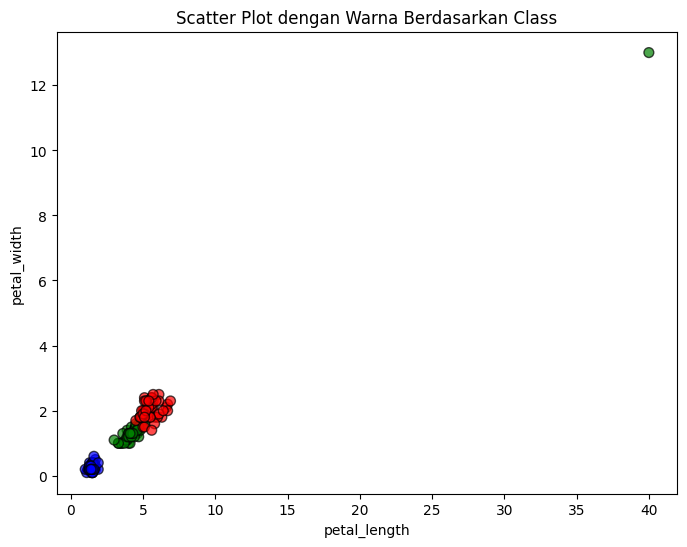

In [29]:
import matplotlib.pyplot as plt

# Pilih dua fitur untuk scatter plot
x_feature = "petal_length"
y_feature = "petal_width"

# Warna berdasarkan kelas
colors = {"Iris-setosa": "blue", "Iris-versicolor": "green", "Iris-virginica": "red"}
df_cleaned["color"] = df_cleaned["class"].map(colors)

# Plot scatter dengan ukuran (s) dan warna (c)
plt.figure(figsize=(8, 6))
plt.scatter(df_cleaned[x_feature], df_cleaned[y_feature], s=50, c=df_cleaned["color"], alpha=0.7, edgecolors="k")
plt.xlabel(x_feature)
plt.ylabel(y_feature)
plt.title("Scatter Plot dengan Warna Berdasarkan Class")
plt.show()

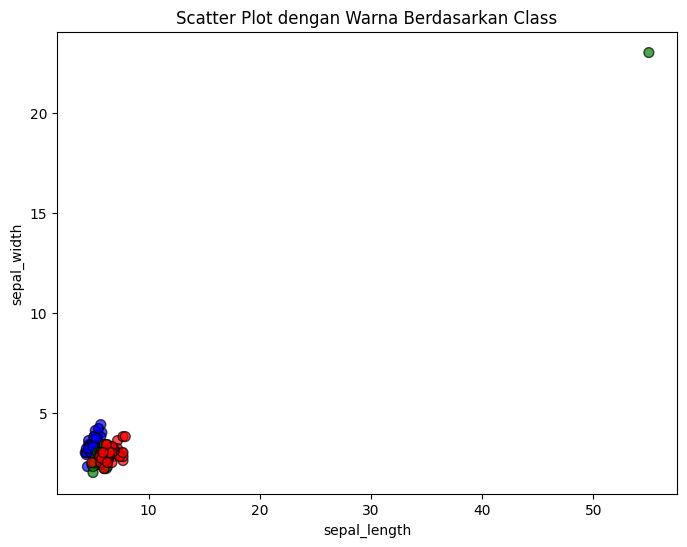

In [30]:
import matplotlib.pyplot as plt

# Pilih dua fitur untuk scatter plot
x_feature = "sepal_length"
y_feature = "sepal_width"

# Warna berdasarkan kelas
colors = {"Iris-setosa": "blue", "Iris-versicolor": "green", "Iris-virginica": "red"}
df_cleaned["color"] = df_cleaned["class"].map(colors)

# Plot scatter dengan ukuran (s) dan warna (c)
plt.figure(figsize=(8, 6))
plt.scatter(df_cleaned[x_feature], df_cleaned[y_feature], s=50, c=df_cleaned["color"], alpha=0.7, edgecolors="k")
plt.xlabel(x_feature)
plt.ylabel(y_feature)
plt.title("Scatter Plot dengan Warna Berdasarkan Class")
plt.show()